<CENTER>
</br>
<p><font size="5">  M2MO & EY - Internship </font></p>
<p><font size="5">  Modelling Forward Initial Margin and Counterparty Risk in Uncleared Derivatives </font></p>
<p><font size="4">  SANGLIER Nathan </font></p>
<p><font size="3"></br>September 2025</font></br></div>
<p><span style="color:blue">nathan.sanglier@fr.ey.com</span>
</p>
</CENTER>

This notebook presents a tutorial for estimating forward IM based on the models implemented (analytical formula, nested MC, GLSMC, JLSMC, JPMMC, neural netxworks quantile regression). It shows how to simulate risk factors paths, portfolio price paths, and forward IM paths for the two case studies considered: a European put option where the stock price follows a Black-Scholes dynamics, and a swaption xhere the riskfree rate follows a one factor Hull-White dynamics.

## <span id="section-0" style="color:#00B8DE"> 0 - Imports </span>

In [1]:
import  numpy               as      np
import  matplotlib.pyplot   as      plt
from    utils               import  TimeGrid
from    pricing_models      import  BlackScholes, YieldCurve, OneFactorHullWhite
from    pricing_engines     import  PutBlackScholes, SwaptionOneFactorHullWhite
from    forward_im_models   import  AnalyticalForwardInitialMargin, NestedMonteCarloForwardInitialMargin, GaussianLeastSquaresMonteCarlo, JohnsonLeastSquaresMonteCarlo, JohnsonPercentileMatchingMonteCarlo, NeuralQuantileRegression

In [2]:
np.random.seed(0)
plt.style.use('ggplot')

## <span id="section-1" style="color:#00B8DE"> I - Parameters </span>

In [3]:
num_paths   = 10000
maturity    = 1
time_grid   = TimeGrid(1/240, maturity)
alpha       = 0.99
mpor        = 1/24

In [4]:
moment_matching_setting     = {'method': 'LR', 'ridge': 0, 'basis_type': 'laguerre', 'order': 2, 'regress_mean': False}
percentile_matching_setting = {'fitting': 'pm', 'Nnmc': 1000, 'z': 1}
support_values_setting      = {'initial nb': 100, 'perc add tails': 0.1, 'add ends': False}
quantile_function_setting   = {'method': 'kNN', 'n_neighbors':3}
nn_function_setting         = {'batch_size': 1000, 'n_neurons': 10, 'n_hidden_layers': 1, 'optimizer': 'adam', 'learning_rate': 0.01, 'ridge': 0.001, 'n_epochs': 50}

num_nested_dates = 3
num_nested_paths = 500
time_grid_nested = TimeGrid(time_grid.time_horizon/(num_nested_dates-1), time_grid.time_horizon)

## <span id="section-0" style="color:#00B8DE"> II - European Put Option Black Scholes </span>

In [ ]:
risk_factor = BlackScholes(0.3, 0.05, 100)
portfolio   = PutBlackScholes(95, maturity, risk_factor)
risk_factor.set_time_grid(time_grid)
risk_factor_paths   = risk_factor.generate_paths(num_paths)
mtm_paths           = portfolio.generate_paths(risk_factor_paths)

In [ ]:
groundtruth = AnalyticalForwardInitialMargin(alpha, mpor, time_grid, portfolio)
model_glsmc = GaussianLeastSquaresMonteCarlo(alpha, mpor, time_grid, moment_matching_setting)
model_glsmc.fit(mtm_paths)
'''
model_nmc = NestedMonteCarloForwardInitialMargin(alpha, mpor, time_grid_nested, portfolio, num_nested_paths)
model_jlsmc = JohnsonLeastSquaresMonteCarlo(alpha, mpor, time_grid, moment_matching_setting, support_values_setting, quantile_function_setting)
model_jlsmc.fit(mtm_paths)
model_jpmmc = JohnsonPercentileMatchingMonteCarlo(alpha, mpor, time_grid, percentile_matching_setting, support_values_setting, quantile_function_setting)
model_jpmmc.fit(risk_factor_paths, mtm_paths, portfolio)
model_ml = NeuralQuantileRegression(alpha, mpor, time_grid, nn_function_setting)
model_ml.fit(risk_factor_paths, mtm_paths)
'''

im_true_paths   = groundtruth.generate_paths(risk_factor_paths, mtm_paths)
im_glsmc_paths  = model_glsmc.generate_paths(mtm_paths)
'''
im_nmc_paths    = model_nmc.generate_paths(risk_factor_paths, mtm_paths)
im_jlsmc_paths  = model_jlsmc.generate_paths(mtm_paths)
im_jpmmc_paths  = model_jpmmc.generate_paths(mtm_paths)
im_ml_paths     = model_ml.generate_paths(risk_factor_paths)
'''

im_true_profile     = groundtruth.generate_im_profile(im_true_paths)
im_glsmc_profile    = model_glsmc.generate_im_profile(im_glsmc_paths)
'''
im_nmc_profile      = model_nmc.generate_im_profile(im_nmc_paths)
im_jlsmc_profile    = model_jlsmc.generate_im_profile(im_jlsmc_paths)
im_jpmmc_profile    = model_jpmmc.generate_im_profile(im_jpmmc_paths)
im_ml_profile       = model_ml.generate_im_profile(im_ml_paths)
'''

Fitting GLSMC...
Fitting ML...
Generating groundtruth IM paths...
Generating GLSMC IM paths...


'\nim_jlsmc_profile    = model_jlsmc.generate_im_profile(im_jlsmc_paths)\nim_jpmmc_profile    = model_jpmmc.generate_im_profile(im_jpmmc_paths)\nim_ml_profile       = model_ml.generate_im_profile(im_ml_paths)\n'

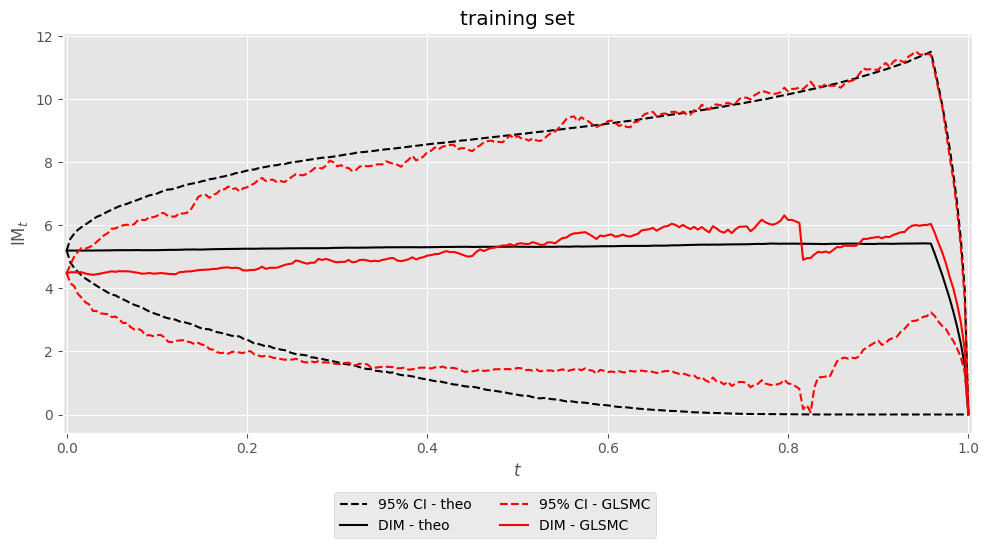

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

groundtruth.plot_im_profile(im_true_profile, ax)
model_glsmc.plot_im_profile(im_glsmc_profile, ax)
'''
#model_nmc.plot_im_profile(im_nmc_profile, ax)
#model_jlsmc.plot_im_profile(im_jlsmc_profile, ax)
#model_jpmmc.plot_im_profile(im_jpmmc_profile, ax)
#model_ml.plot_im_profile(im_ml_profile, ax)
'''

ax.set_xlabel('$t$')
ax.set_ylabel('$\\text{IM}_t$')
ax.set_xlim(np.min(time_grid.grid)-time_grid.timestep, np.max(time_grid.grid)+time_grid.timestep)
ax.set_title('training set')

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.1))
plt.tight_layout()
plt.show()

## <span id="section-3" style="color:#00B8DE"> III - Swaption One Factor Hull-White </span>

In [ ]:
risk_factor = OneFactorHullWhite(0.01, 0.015, YieldCurve(0.05, -0.03, -0.18))
portfolio   = SwaptionOneFactorHullWhite(maturity, 0.04, TimeGrid(0.25, 4.75), 10000, risk_factor)
risk_factor.set_time_grid(time_grid)
risk_factor_paths   = risk_factor.generate_paths(num_paths)
mtm_paths           = portfolio.generate_paths(risk_factor_paths)

In [144]:
## Analytical ##
groundtruth = AnalyticalForwardInitialMargin(alpha, mpor, time_grid, portfolio)
## NMC ##
model_nmc = NestedMonteCarloForwardInitialMargin(alpha, mpor, time_grid_nested, portfolio, num_nested_paths)
## GLSMC ##
model_glsmc = GaussianLeastSquaresMonteCarlo(alpha, mpor, time_grid, moment_matching_setting)
print('Fitting GLSMC...')
model_glsmc.fit(mtm_paths)
## JLSMC ##
model_jlsmc = JohnsonLeastSquaresMonteCarlo(alpha, mpor, time_grid, moment_matching_setting, support_values_setting, quantile_function_setting)
print('Fitting JLSMC...')
model_jlsmc.fit(mtm_paths)
## JPMMC ##
model_jpmmc = JohnsonPercentileMatchingMonteCarlo(alpha, mpor, time_grid, percentile_matching_setting, support_values_setting, quantile_function_setting)
print('Fitting JPMMC...')
model_jpmmc.fit(risk_factor_paths, mtm_paths, portfolio)

print('Generating groundtruth IM paths...')
im_true_paths   = groundtruth.generate_paths(risk_factor_paths, mtm_paths)
print('Generating NMC IM paths...')
im_nmc_paths    = model_nmc.generate_paths(risk_factor_paths, mtm_paths)
print('Generating GLSMC IM paths...')
im_glsmc_paths  = model_glsmc.generate_paths(mtm_paths)
print('Generating JLSMC IM paths...')
im_jlsmc_paths  = model_jlsmc.generate_paths(mtm_paths)
print('Generating JPMMC IM paths...')
im_jpmmc_paths  = model_jpmmc.generate_paths(mtm_paths)

im_true_profile     = groundtruth.generate_im_profile(im_true_paths)
im_nmc_profile      = model_nmc.generate_im_profile(im_nmc_paths)
im_glsmc_profile    = model_glsmc.generate_im_profile(im_glsmc_paths)
im_jlsmc_profile    = model_jlsmc.generate_im_profile(im_jlsmc_paths)
im_jpmmc_profile    = model_jpmmc.generate_im_profile(im_jpmmc_paths)

Fitting GLSMC...
Fitting JLSMC...
Fitting JPMMC...
Generating groundtruth IM paths...
Generating NMC IM paths...
Generating GLSMC IM paths...
Generating JLSMC IM paths...
Generating JPMMC IM paths...


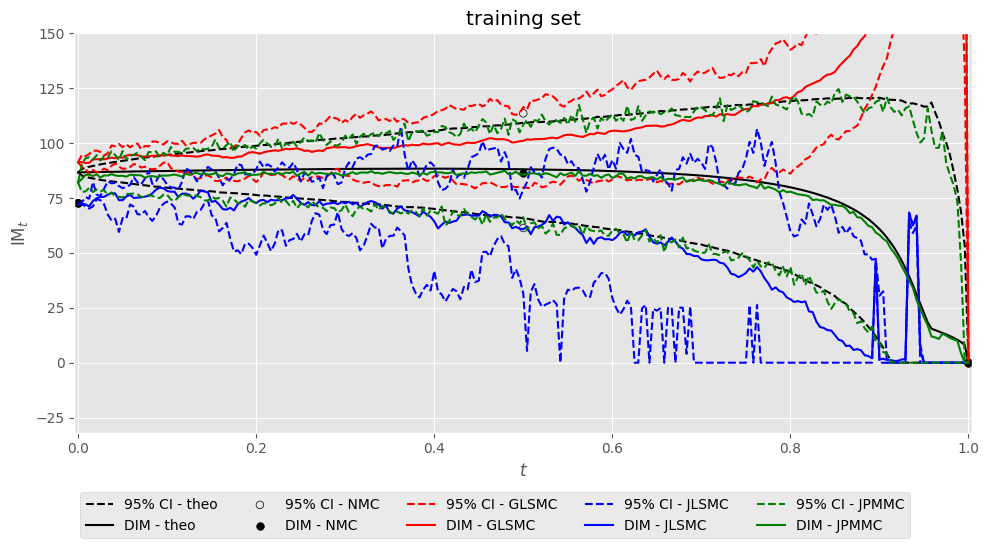

In [146]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.plot(time_grid.grid, im_true_profile[2], linestyle='--', color='black', label='95% CI - theo')
ax.plot(time_grid.grid, im_true_profile[1], color='black', label='DIM - theo')
ax.plot(time_grid.grid, im_true_profile[0],  linestyle='--', color='black')

ax.scatter(time_grid_nested.grid, im_nmc_profile[2], s=30, facecolors='none', color='black', label='95% CI - NMC')
ax.scatter(time_grid_nested.grid, im_nmc_profile[1], s=30, color='black', label='DIM - NMC')
ax.scatter(time_grid_nested.grid, im_nmc_profile[0], s=30, facecolors='none', color='black')

ax.plot(time_grid.grid, im_glsmc_profile[2], linestyle='--', color='red', label='95% CI - GLSMC')
ax.plot(time_grid.grid, im_glsmc_profile[1], color='red', label='DIM - GLSMC')
ax.plot(time_grid.grid, im_glsmc_profile[0], linestyle='--', color='red')

ax.plot(time_grid.grid, im_jlsmc_profile[2], linestyle='--', color='blue', label='95% CI - JLSMC')
ax.plot(time_grid.grid, im_jlsmc_profile[1], color='blue', label='DIM - JLSMC')
ax.plot(time_grid.grid, im_jlsmc_profile[0], linestyle='--', color='blue')

ax.plot(time_grid.grid, im_jpmmc_profile[2], linestyle='--', color='green', label='95% CI - JPMMC')
ax.plot(time_grid.grid, im_jpmmc_profile[1], color='green', label='DIM - JPMMC')
ax.plot(time_grid.grid, im_jpmmc_profile[0], linestyle='--', color='green')

ax.set_xlabel('$t$')
ax.set_ylabel('$\\text{IM}_t$')
ax.set_xlim(np.min(time_grid.grid)-time_grid.timestep, np.max(time_grid.grid)+time_grid.timestep)
ax.set_ylim(top=150)
ax.set_title('training set')

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.1))
plt.tight_layout()
plt.show()